# Pre processing

## Imports

Modules import

In [ ]:
from scipy.stats import norm
from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

Data import

In [ ]:
data = pd.read_csv('airbus_cours.csv', delimiter=",")

## Data processing

Cleaning

In [ ]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data["Close"] = data["Close"].astype(float)

Returns calculation

In [ ]:
stock_values = data['Close']
returns = np.zeros(len(stock_values))
for i in range(1, len(stock_values)):
    returns[i] = (stock_values[i] - stock_values[i-1]) / stock_values[i-1] * 100
data['returns'] = returns
data['returns'] = data['returns'].round(3)
data = data[["Date","Close","returns"]]
returns = data['returns']
stock_values = data["Close"]

## Data visualisation

In [ ]:
data.head(10)

,Date,Close,returns
0,2022-11-21,114.180000,0.000
1,2022-11-22,114.080002,-0.088
2,2022-11-23,113.760002,-0.281
3,2022-11-24,113.260002,-0.440
4,2022-11-25,113.820000,0.494
5,2022-11-28,107.360001,-5.676
6,2022-11-29,109.180000,1.695
7,2022-11-30,109.199997,0.018
8,2022-12-01,110.139999,0.861
9,2022-12-02,110.980003,0.763


Stock prices

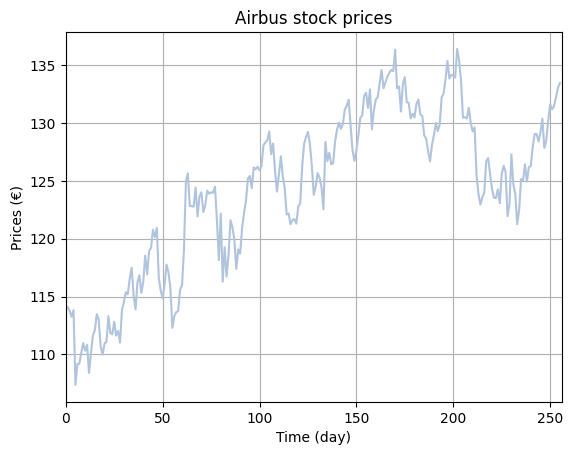

In [ ]:
plt.plot(stock_values,color='lightsteelblue')
plt.title("Airbus stock prices")
plt.xlabel("Time (day)")
plt.ylabel("Prices (€)")
plt.xlim(0,len(stock_values))
plt.grid(True)
plt.show()

Returns

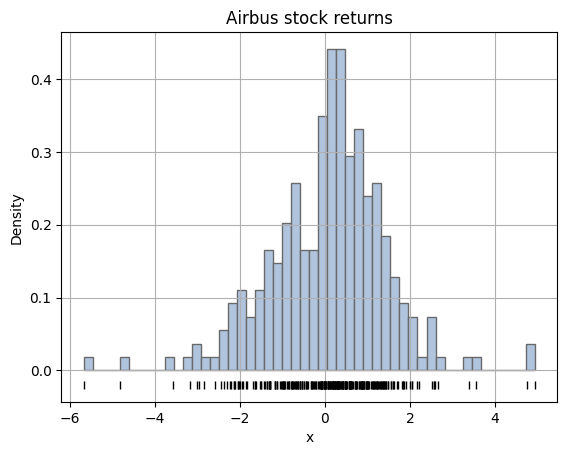

In [ ]:
plt.hist(returns, bins=50, density=True,edgecolor='dimgrey', color='lightsteelblue')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)
plt.title('Airbus stock returns')
plt.plot(returns, np.full_like(returns, -0.02), '|k', markeredgewidth=1,color="black")
plt.show()

## Statistical tools

In [ ]:
def moyenne(data):
  somme = 0
  for i in range(len(data)):
    somme += data[i]
  return somme / len(data)

In [ ]:
def ecart_type(data):
  mean = moyenne(data)
  somme = 0
  for i in range(len(data)):
    somme += (data[i]-mean)**2
  return (somme / len(data))**0.5

In [ ]:
def variance(data):
  mean = moyenne(data)
  somme = 0
  for i in range(len(data)):
    somme += (data[i]-mean)**2
  return (somme / len(data))

In [ ]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call = S * norm.cdf(d1) -  norm.cdf(d2)* K * np.exp(-r * T)
    return call

In [ ]:
def vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / sigma * np.sqrt(T)
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return vega

# Volatility estimations

## Newton-Raphson

Get the implied volatility from an observed call

In [ ]:
def newton_raphson(C, S, K, T, r, tol=0.0001,max_iterations=100,sigma = 0.2):
    for i in range(max_iterations):
        diff = black_scholes_call(S, K, T, r, sigma) - C
        if abs(diff) < tol:
            break
        sigma = sigma - diff / vega(S, K, T, r, sigma)
    return sigma

In [ ]:
C = 4.96
S = 133.48
K = 130
T = 24/365
r = 3.99/100
imp_vol = round(newton_raphson(C, S, K, T, r),3)
print('Implied volatility using Newton Rapshon is:', imp_vol)

Implied volatility using Newton Rapshon is: 0.195


## ARCH

In [ ]:
alpha0 = np.var(returns)
alpha1 = 0.2  #  a ajuster
beta1 = 0.7  # a ajuster

# Calculer les résidus
residuals = returns**2 - alpha0 - alpha1 * returns[:-1]**2

# Calculer la volatilité estimée
volatility = np.sqrt(alpha0 + alpha1 * returns[:-1]**2 + beta1 * residuals[:-1]**2)

# Ajouter la volatilité estimée à votre DataFrame
data['volatility'] = np.nan
data['volatility'][1:] = volatility

# Afficher le DataFrame résultant
daily_volatility_mean = data['volatility'].mean()

# Définir le nombre de jours de négociation par an (252 est couramment utilisé)
days_per_year = 252

# Calculer la volatilité annuelle moyenne en pourcentage
annual_volatility_mean = daily_volatility_mean * np.sqrt(days_per_year)

# Afficher la volatilité annuelle moyenne en pourcentage
print(f"Volatilité annuelle moyenne en pourcentage : {annual_volatility_mean:.2f}%")

Volatilité annuelle moyenne en pourcentage : 35.57%


## Stochastic volatiliy with Heston

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_heston_model(kappa, theta, sigma, mu, stock_values, dates):
    # Calcul de la durée T et du pas de temps dt
    T = len(stock_values)
    dt = 1  # Période de temps (1 jour)


    V = np.zeros(T)
    S = np.zeros(T)
    V[0] = theta  # Initialisation de la volatilité
    S[0] = stock_values[0]  # Initialisation du prix du stock

    # Simulation du modèle de Heston avec contrainte de positivité de la volatilité
    for t in range(1, T):
        dW1 = np.random.normal(0, np.sqrt(dt))
        dW2 = np.random.normal(0, np.sqrt(dt))

        # Mise à jour de la volatilité avec contrainte de positivité
        dV = kappa * (theta - max(V[t-1], 0)) * dt + sigma * np.sqrt(max(V[t-1], 0)) * dW1
        V[t] = max(V[t-1] + dV, 0)

        dS = mu * S[t-1] * dt + np.sqrt(max(V[t-1], 0)) * S[t-1] * dW2
        S[t] = S[t-1] + dS

    # Estimation de la volatilité sigma_t
    sigma_t = np.sqrt(np.maximum(V, 0))
    volatility_mean_percentage = np.mean(sigma_t) * 100
    #print(sigma_t)
    print(f"Volatilité moyenne en pourcentage : {volatility_mean_percentage:.2f}%")
    return sigma_t


kappa = 1.0
theta = 0.04
sigma = 0.3
mu = 0.05
stock_values = data['Close']
dates = data['Date']

simulate_heston_model(kappa, theta, sigma, mu, stock_values, dates)
#Dans sigma_t tu a la vol de chaque jour c'est ce que t'aura besoin pour la suite je pense

Volatilité moyenne en pourcentage : 18.17%


array([0.2       , 0.        , 0.2       , 0.08225738, 0.20525546,
       0.        , 0.2       , 0.20217197, 0.38409498, 0.18101277,
       0.20065976, 0.11158498, 0.12631453, 0.24178573, 0.        ,
       0.2       , 0.31108375, 0.22518033, 0.        , 0.2       ,
       0.        , 0.2       , 0.        , 0.2       , 0.18775236,
       0.30950759, 0.14766004, 0.19706291, 0.        , 0.2       ,
       0.35928726, 0.29573004, 0.304863  , 0.        , 0.2       ,
       0.22995603, 0.38154446, 0.30289297, 0.19101561, 0.        ,
       0.2       , 0.21819979, 0.        , 0.2       , 0.14103818,
       0.21632968, 0.39588172, 0.36053239, 0.        , 0.2       ,
       0.288135  , 0.30300741, 0.32857001, 0.11000351, 0.24777377,
       0.        , 0.2       , 0.32583826, 0.22983797, 0.49849754,
       0.        , 0.2       , 0.2298566 , 0.29239974, 0.        ,
       0.2       , 0.        , 0.2       , 0.07886682, 0.21292806,
       0.31473648, 0.0833516 , 0.22780029, 0.        , 0.2    

# Price simulations


## Density of the returns

In [ ]:
def silverman_bandwidth(data):
    sigma = ecart_type(data)
    n = len(data)
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    bandwidth = 0.9 * np.minimum(sigma, iqr/1.34) * n**(-0.2)
    return bandwidth

In [ ]:
h_silverman = round(silverman_bandwidth(returns),3)
print(f"An estimation of the bandwidth with Silverman's ROT is : ", h_silverman)

An estimation of the bandwidth with Silverman's ROT is :  0.358


In [ ]:
def kernel_density_estimate(data, x, bandwidth):
    kernel_vals = norm.pdf(((x - data) / bandwidth))
    return np.sum(kernel_vals) / (len(data) * bandwidth)

## Monte Carlo return sampling


In [ ]:
def sample_returns(k, data, h):
  samples = []
  while(len(samples) != k):
    x = np.random.uniform(min(data)-1, max(data)-1)
    density = kernel_density_estimate(data, x, h)
    u = np.random.random()
    const =max(data)+1 - (min(data)-1)
    m = 0.4
    if u < density / m * (1/const):
      samples.append(x)
  return samples

In [ ]:
print(type(returns))
sampled_returns = sample_returns(100, returns, h_silverman)

<class 'pandas.core.series.Series'>


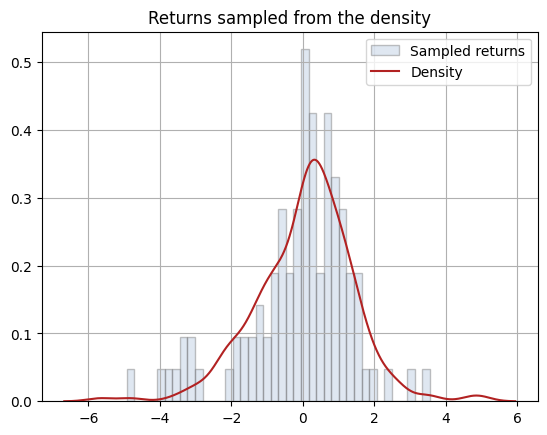

In [ ]:
x_values = np.linspace(np.min(returns)-1, np.max(returns)+1, 1000)
density = [kernel_density_estimate(returns, x, h_silverman) for x  in x_values]
plt.hist(sampled_returns, bins=40, density=True,edgecolor='dimgrey', alpha=0.4, color='lightsteelblue',label="Sampled returns")
plt.plot(x_values, density,color ='firebrick',label="Density")
plt.legend()
plt.grid(True)
plt.title("Returns sampled from the density")
plt.show()

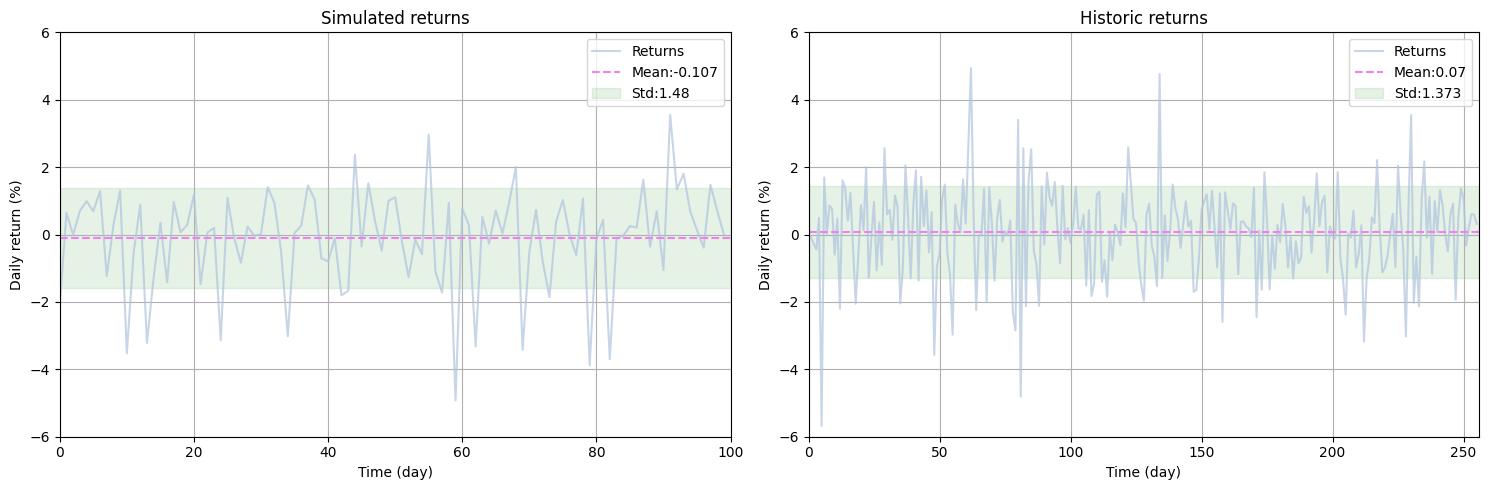

In [ ]:
mean_simu = round(np.mean(list(sampled_returns)),3)
sigma_simu = round(np.std(sampled_returns),3)
string = "Mean:" +str(mean_simu)
string2 = "Std:" +str(sigma_simu)

mean_hist = round(np.mean(list(returns)),3)
sigma_hist = round(np.std(returns),3)
string3 = "Mean:" +str(mean_hist)
string4 = "Std:" +str(sigma_hist)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 5))

ax1.plot(sampled_returns,label="Returns",color='lightsteelblue',alpha=0.7)
ax1.axhline(mean_simu,color='violet',linestyle="--",label=string)
ax1.axhspan(mean_simu-sigma_simu, mean_simu+sigma_simu, color='g', alpha=0.1,label=string2)
ax1.set_title("Simulated returns")
ax1.set_xlabel("Time (day)")
ax1.set_ylim(-6,6)
ax1.set_xlim(0,len(sampled_returns))
ax1.set_ylabel("Daily return (%)")
ax1.legend()
ax1.grid(True)

ax2.plot(returns,label="Returns",color='lightsteelblue',alpha=0.7)
ax2.axhline(mean_hist,color='violet',linestyle="--",label=string3)
ax2.axhspan(mean_hist-sigma_hist, mean_hist+sigma_hist, color='g', alpha=0.1,label=string4)
ax2.set_title("Historic returns")
ax2.set_xlabel("Time (day)")
ax2.set_ylabel("Daily return (%)")
ax2.set_ylim(-6,6)
ax2.set_xlim(0,len(returns))
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Get n simulation of the price at time horizon k

In [ ]:
def simulate_prices(S0, daily_returns):
  n_days = len(daily_returns)
  prices = np.empty(n_days)
  prices[0] = S0
  for i in range(1,n_days):
    prev_price = prices[i-1]
    daily_return = daily_returns[i-1]
    new_price = prev_price * (1 + (daily_return/100))
    prices[i] = new_price
  return prices

In [ ]:
def get_k_price(k, data, last_price, h):
  sampled_returns = sample_returns(k, data, h)
  simulated_prices = simulate_prices(last_price, sampled_returns)
  return round(simulated_prices[k-1],3)

In [ ]:
def n_simu(n, k, data, last_price, h):
  prices_simulation = []
  for _ in range(n):
    prices_simulation.append(get_k_price(k, data, last_price, h))
  return prices_simulation

In [ ]:
S0 = data["Close"].iloc[-1]
n_prices = n_simu(10000, 5, returns, S0, h_silverman)

In [ ]:
quantile = sorted(n_prices)[int(0.05*len(n_prices))]
print("Quantile des prix au niveau alpha = 0.05 :",quantile)

Quantile des prix au niveau alpha = 0.05 : 127.51


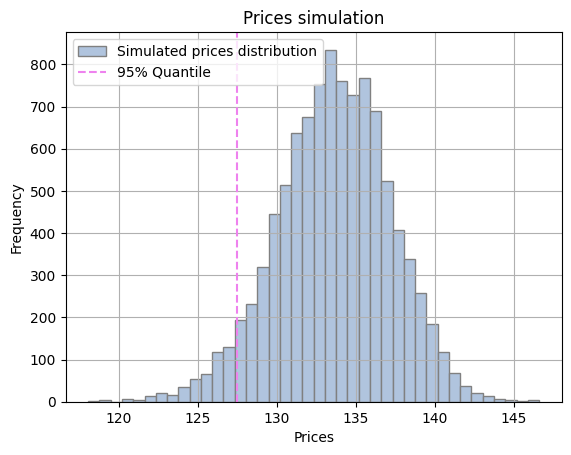

In [ ]:
plt.hist(n_prices, bins=40, color="lightsteelblue",edgecolor="grey",label="Simulated prices distribution")
plt.axvline(quantile, color="violet", linestyle="--",label="95% Quantile")
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.legend()
plt.title("Prices simulation")
plt.grid(True)
plt.show()

# Call option

## Call prices

In [ ]:
call_prices =[]
for i in range(len(n_prices)):
  call_prices.append(black_scholes_call(n_prices[i], K, T, r, imp_vol))

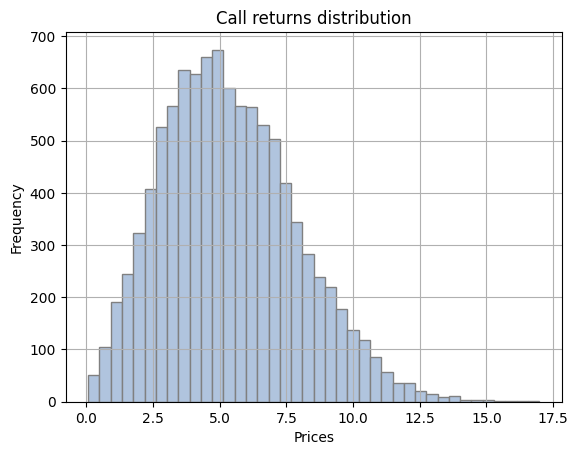

In [ ]:
plt.hist(call_prices, bins=40, color="lightsteelblue",edgecolor="grey")
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.title("Call returns distribution")
plt.grid(True)
plt.show()

## Call returns and VaR

In [ ]:
VaR_simu = round((black_scholes_call(quantile, K, T, r, imp_vol) - 4.96)/4.96,3)
print("Value at Risk du call :",VaR_simu)

Value at Risk du call : -0.671


In [ ]:
call_return = np.zeros(len(call_prices))
for i in range(1, len(call_prices)):
    call_return[i] = (call_prices[i] - call_prices[i-1]) / call_prices[i-1]

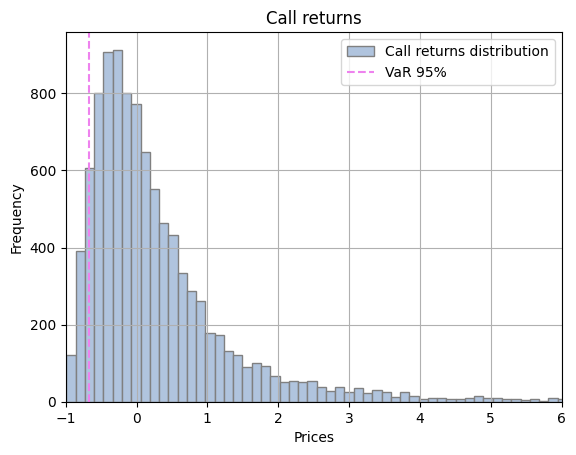

In [ ]:
plt.hist(call_return, bins=500, color="lightsteelblue",edgecolor="grey",label="Call returns distribution")
plt.axvline(VaR_simu, color="violet", linestyle="--",label="VaR 95%")
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.xlim(-1, 6)
plt.legend()
plt.title("Call returns")
plt.grid(True)
plt.show()

In [ ]:
nb_VaR = 0
for i in range(len(call_return)):
  if(call_return[i] < VaR_simu):
    nb_VaR += 1
print(nb_VaR,"over", len(call_return),"call prices are exceeding the VaR threshold")
print("Corresponding to",nb_VaR/len(call_return)*100,"% for a VaR 95%")

736 over 10000 call prices are exceeding the VaR threshold
Corresponding to 7.359999999999999 % for a VaR 95%
